<h1>Importing Libraries</h1>

In [1]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import imutils
import time
import cv2
import numpy as np
import face_recognition
import os
import pandas as pd
from datetime import datetime

<h1>Mark Attendance Function</h1>

In [2]:
def clearAttendanceFiles():
    # Clear Attendance.csv
    attendance_file = 'Attendance.csv'
    if os.path.exists(attendance_file):
        with open(attendance_file, 'w') as f:
            f.write('Name,Entry Time,Exit Time\n')
        print(f'[INFO] Cleared {attendance_file}')

    # Clear Output.csv
    output_file = 'output.csv'
    if os.path.exists(output_file):
        with open(output_file, 'w') as f:
            f.write('Student Name,Status\n')
        print(f'[INFO] Cleared {output_file}')

In [3]:
entry_times = {}

In [4]:
def markAttendance(name, isEntry=True):
    now = datetime.now()
    timeStr = now.strftime('%H:%M:%S')

    if not os.path.exists('Attendance.csv'):
        with open('Attendance.csv', 'w') as f:
            f.write('Name,Entry Time,Exit Time\n')
    
    with open('Attendance.csv', 'r+') as f:
        myDataList = f.readlines()
        nameList = [line.split(',')[0] for line in myDataList]
        updatedData = []
        if isEntry:
            # Handle entry time
            if name not in nameList:
                # New entry
                entry_times[name] = timeStr
                updatedData = myDataList
                updatedData.append(f'\n{name},{timeStr},-')
            else:
                # Update existing entry with a new entry time
                for line in myDataList:
                    if name in line:
                        updatedData.append(f'{name},{timeStr},-\n')
                        entry_times[name] = timeStr
                    else:
                        updatedData.append(line)
        else:
            # Handle exit time update when the program is closing
            for line in myDataList:
                if name in line:
                    entry_time = entry_times.get(name, line.split(',')[1])
                    updatedData.append(f'{name},{entry_time},{timeStr}\n')
                else:
                    updatedData.append(line)

        f.seek(0)
        f.truncate(0)
        f.writelines(updatedData)

In [5]:
def updateExitTimes():
    with open('Attendance.csv', 'r+') as f:
        myDataList = f.readlines()
        updatedData = []
        now = datetime.now()
        timeStr = now.strftime('%H:%M:%S')

        for line in myDataList:
            if '-' in line:  # If exit time is not updated yet
                name, entry_time, _ = line.strip().split(',')
                updatedData.append(f'{name},{entry_time},{timeStr}\n')
            else:
                updatedData.append(line)

        f.seek(0)
        f.truncate(0)
        f.writelines(updatedData)

<h1>Face Encoding Function</h1>

In [6]:
def findEncodings(images):
    encodeList = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        encode = face_recognition.face_encodings(img)[0]
        encodeList.append(encode)
    return encodeList

<h1>Mask Detection Function</h1>

In [7]:
def detect_and_predict_mask(frame, faceNet, maskNet, confidence_threshold=0.5):
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), (104.0, 177.0, 123.0))
    faceNet.setInput(blob)
    detections = faceNet.forward()

    faces = []
    locs = []
    preds = []

    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > confidence_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype('int')
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            faces.append(face)
            locs.append((startX, startY, endX, endY))

    if len(faces) > 0:
        faces = np.array(faces, dtype='float32')
        preds = maskNet.predict(faces, batch_size=32)

    return (locs, preds)

<h1>Loading Models and Encoding Faces</h1>

In [8]:
print('[INFO] Loading face detector model...')
prototxtPath = os.path.join('face_detector', 'deploy.prototxt')
weightsPath = os.path.join('face_detector', 'res10_300x300_ssd_iter_140000.caffemodel')
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

print('[INFO] Loading face mask detector model...')
maskNet = load_model('mask_detector.h5')

imgAttendance = 'ImagesAttendance'
images = [cv2.imread(f'{imgAttendance}/{img}') for img in os.listdir(imgAttendance)]
classNames = [os.path.splitext(cls)[0].upper() for cls in os.listdir(imgAttendance)]
encodeListKnown = findEncodings(images)
print('Encoding Complete')

[INFO] Loading face detector model...
[INFO] Loading face mask detector model...


Encoding Complete


<h1>Video Stream and Real-Time Processing</h1>

In [9]:
clearAttendanceFiles()
vs = VideoStream(src=0).start()
time.sleep(2.0)
violation_dir = 'violations'
os.makedirs(violation_dir, exist_ok=True)
violationFlag = False

try:
    while True:
        frame = vs.read()
        frame = imutils.resize(frame, width=600)

        faceCurFrame = face_recognition.face_locations(frame)
        encodeCurFrame = face_recognition.face_encodings(frame, faceCurFrame)

        (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

        for (box, pred) in zip(locs, preds):
            (startX, startY, endX, endY) = box
            (mask, withoutMask) = pred

            label = 'Mask' if mask > withoutMask else 'No Mask'
            color = (0, 255, 0) if label == 'Mask' else (0, 0, 255)

            if label == 'No Mask' and not violationFlag:
                violation_image_path = os.path.join(violation_dir, f'violation_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png')
                cv2.imwrite(violation_image_path, frame)
                print(f'[INFO] No mask violation image saved at {violation_image_path}')
                violationFlag = True

            for encodeFace, faceLoc in zip(encodeCurFrame, faceCurFrame):
                matches = face_recognition.compare_faces(encodeListKnown, encodeFace)
                faceDist = face_recognition.face_distance(encodeListKnown, encodeFace)
                matchIndex = np.argmin(faceDist)
                if matches[matchIndex]:
                    name = classNames[matchIndex]
                    cv2.putText(frame, name, (startX, endY), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
                    markAttendance(name, isEntry=True)

            cv2.putText(frame, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

        cv2.imshow('Frame', frame)
        if cv2.waitKey(1) & 0xFF == 27:  # Press 'Esc' to exit
            break

finally:
    updateExitTimes()
    cv2.destroyAllWindows()
    vs.stop()

[INFO] Cleared Attendance.csv
[INFO] Cleared output.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
[INFO] No mask violation image saved at violations\violation_20250303_211757.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


<h1>Generating the Attendance Report</h1>

In [10]:
df = pd.read_csv('Attendance.csv')
present_students = set(df['Name'].str.upper())
all_students = pd.read_csv('Students.csv')['Name'].str.upper()

result = pd.DataFrame([(name, 'Present' if name in present_students else 'Absent') 
                       for name in all_students], columns=['Student Name', 'Status'])

output_csv = 'output.csv'
result.to_csv(output_csv, index=False)
print(f'[INFO] Attendance report saved to {output_csv}')

[INFO] Attendance report saved to output.csv


Available columns in Attendance.csv: Index(['Name', 'Entry Time', 'Exit Time'], dtype='object')


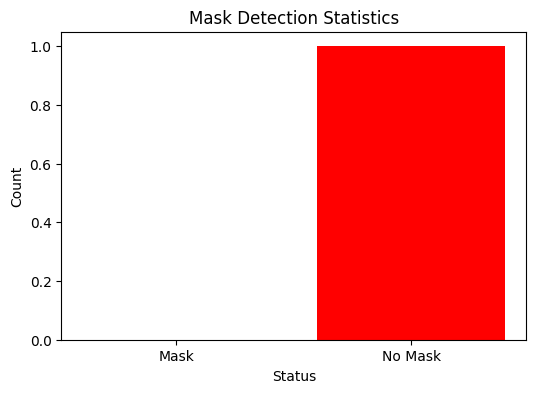

[INFO] Mask detection statistics plot saved as mask_detection_stats.png


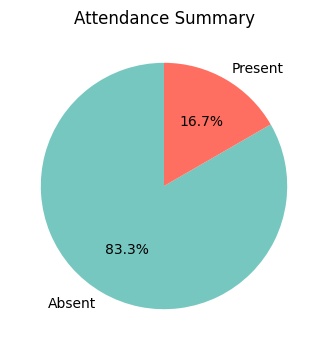

[INFO] Attendance summary plot saved as attendance_summary.png


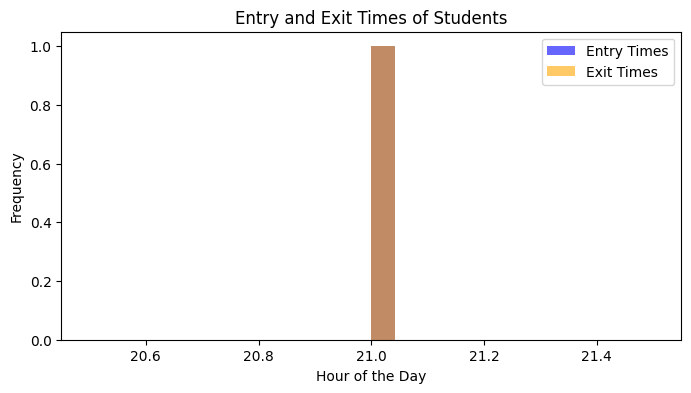

[INFO] Entry and exit times plot saved as entry_exit_times.png


In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the attendance data and strip whitespace from column names
attendance_df = pd.read_csv('Attendance.csv')
attendance_df.columns = attendance_df.columns.str.strip()
output_df = pd.read_csv('output.csv')

# Check available columns
print("Available columns in Attendance.csv:", attendance_df.columns)

# Calculate Mask vs. No Mask counts based on the attendance file
mask_count = attendance_df['Name'].str.contains('Mask').sum()
no_mask_count = len(attendance_df) - mask_count

# 1. Plot Mask vs. No Mask Statistics
mask_counts = {'Mask': mask_count, 'No Mask': no_mask_count}
plt.figure(figsize=(6, 4))
plt.bar(mask_counts.keys(), mask_counts.values(), color=['green', 'red'])
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Mask Detection Statistics')
plt.savefig('mask_detection_stats.png')
plt.show()
plt.close()
print('[INFO] Mask detection statistics plot saved as mask_detection_stats.png')

# 2. Plot Attendance Summary (Present vs. Absent)
attendance_summary = output_df['Status'].value_counts()
plt.figure(figsize=(6, 4))
plt.pie(attendance_summary, labels=attendance_summary.index, autopct='%1.1f%%', startangle=90, colors=['#76c7c0', '#ff6f61'])
plt.title('Attendance Summary')
plt.savefig('attendance_summary.png')
plt.show()
plt.close()
print('[INFO] Attendance summary plot saved as attendance_summary.png')

# 3. Plot Entry and Exit Times with Error Handling
if 'Entry Time' in attendance_df.columns and 'Exit Time' in attendance_df.columns:
    attendance_df['Entry Time'] = pd.to_datetime(attendance_df['Entry Time'], format='%H:%M:%S')
    attendance_df['Exit Time'] = pd.to_datetime(attendance_df['Exit Time'], format='%H:%M:%S', errors='coerce')
    plt.figure(figsize=(8, 4))
    plt.hist(attendance_df['Entry Time'].dropna().dt.hour, bins=24, alpha=0.6, label='Entry Times', color='blue')
    plt.hist(attendance_df['Exit Time'].dropna().dt.hour, bins=24, alpha=0.6, label='Exit Times', color='orange')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Frequency')
    plt.title('Entry and Exit Times of Students')
    plt.legend()
    plt.savefig('entry_exit_times.png')
    plt.show()
    plt.close()
    print('[INFO] Entry and exit times plot saved as entry_exit_times.png')
else:
    print('[WARNING] Entry Time or Exit Time columns not found in Attendance.csv. Skipping this plot.')